## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, I will employ several supervised algorithms to accurately model individuals' income using data collected from the 1994 U.S. Census. I will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. My goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, I can infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_.

----
## Exploring the Data
In the first step, I will load necessary Python libraries and load the census data. The last column from this dataset, `'income'`, will be my target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Importing libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Importing supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, I will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [3]:
#Total number of records
n_records = data.shape[0]

#Number of records where individual's income is more than $50,000
n_greater_50k = data[data["income"] == ">50K"].shape[0]

#Number of records where individual's income is at most $50,000
n_at_most_50k = data[data["income"] == "<=50K"].shape[0]

#Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

#Printing the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries I must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

I will plot a histogram of these two features.

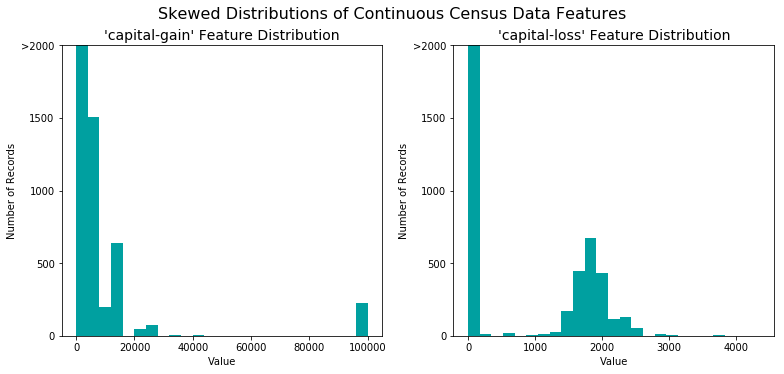

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Now I will perform a transformation on the data and visualize the results.

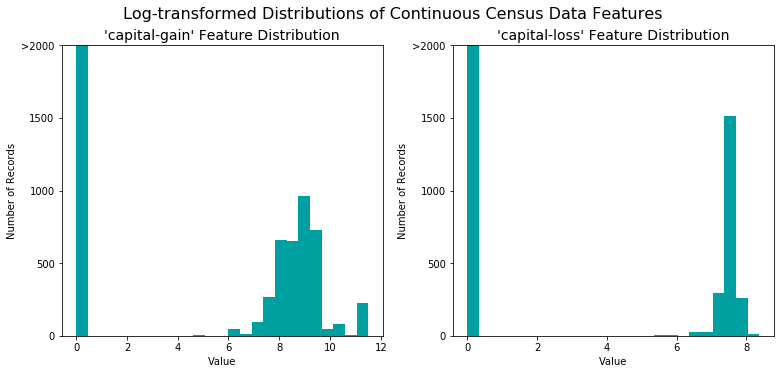

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualizing the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Now I will normalize each numerical feature. I will use [`sklearn.preprocessing.MinMaxScaler`] for this.

In [6]:
# Importing sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initializing a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Showing an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. Then we encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, I need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), I can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, I will need to implement the following:
 - [`pandas.get_dummies()`] to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Setting records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
#One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

#Encode the 'income_raw' data to numerical values
income = income_raw.replace({ '<=50K' : 0, '>50K' : 1})

# Printing the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))



103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features and all numerical features have been normalized. As always, I will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Now I will perform this split.

In [8]:
# Importing train_test_split
from sklearn.cross_validation import train_test_split

# Splitting the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Showing the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, I will investigate four different algorithms and determine which is best at modeling the data. Three of these algorithms will be supervised learners of my choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall.

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors.

### Question 1 - Naive Predictor Performace
* The purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally the base model would be either the results of a previous model or could be based on a research paper upon which we are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place we could start from.

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [9]:

TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

#Calculating accuracy, precision and recall
accuracy = TP/(TP+FP+TN+FN)
recall = TP / (TP+FN)
precision = TP/(TP+FP)

#Calculating F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = ((1+0.5**2) * accuracy * recall)/((0.5**2*precision)+recall)

#Printing the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that we may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
Below there are three of the supervised learning models that are appropriate for this problem that I will test on the census data.

GRADIENT BOOSTING

Application:
-	Face detection systems in real-time, credit score fraud, tracking systems, web-search ranking

Strengths:
-	better accuracy with a smaller amount of trees
-	robustness to outliers in output space
-	flexible to many types of problems and mixed data types

Weaknesses:
-	slower because of sequential tree generation
-	more hyper parameters are needed to tune in compare to i.e. random forests
-	prone to overfitting

A good candidate for this problem?
- As we face large number of data and various decision functions this model can be a good candidate.

SOURCE: https://orbi.uliege.be/bitstream/2268/163521/1/slides.pdf


LOGISTIC REGRESSION:

Application:
-	probability of a banking transaction to be fraudulent, probability of if a user will buy a product or not

Strengths:
-	generalize very well due to single decision boundary
-	fast in training and prediction time compared to random forests or gradient boosting
-	easy to implement and efficient to train

Weaknesses:
-	imbalances in the training dataset may lead to the skewing of the predicted probabilities
-	unable to decipher complex relationships between features
-	incapable of predicting continuous outcomes

A good candidate for this problem?
- We have a binary classification problem with a large amount of data. That’s why, logistic regression can be a good proposition. We can use cross validation to alleviate any potential imbalances in the data set.

SOURCE: https://www.craftonhills.edu/~/media/Files/SBCCD/CHC/About%20CHC/Research%20and%20Planning/Presentations/Using_Logistic_Regression.pdf

ADABOOST CLASSIFIER:

Application:
-	image detection, text classification, identifying players during a football game

Strengths:
-	flexible for classification and regression problems
-   can be used with a wide variety of data: textual, discrete, numeric and combined with any other learning algorithms
-	simple to implement, not prone to overfitting
-	more robust than single estimators

Weaknesses:
-	sensitive to noisy data and outliers
-	dependence on data and weak learner

A good candidate for this problem?
- Ensemble methods are said to be high quality classifiers and AdaBoost is the one of most popular boosting algorithms. The training time should be short which detects important features among lots of them.

SOURCE: http://www.nickgillian.com/wiki/pmwiki.php/GRT/AdaBoost

### Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model I've chosen, it's important that I create a training and predicting pipeline that allows me to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. My implementation here will be used in the following section.
Now I will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`].
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Recording the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Making sure that you set the `beta` parameter!

In [23]:
#Importing two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    #Fitting the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[0:sample_size], y_train[0:sample_size])
    end = time() # Get end time
    
    #Calculating the training time
    results['train_time'] = end - start
        
    #Getting the predictions on the test set(X_test),
    #       then getting predictions on the first 300 training samples(X_train) using .predict()
    start = time() #Getting start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[0:300])
    end = time() #Getting end time
    
    #Calculating the total prediction time
    results['pred_time'] = end - start
            
    #Computing accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[0:300], predictions_train)
        
    #Computing accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #Computing F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[0:300], predictions_train, beta = 0.5)
        
    #Computing F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    #Returning the results
    return results

### Initial Model Evaluation
In the code cell, I will need to implement the following:
- Import the three supervised learning models I've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model I use.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.


LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


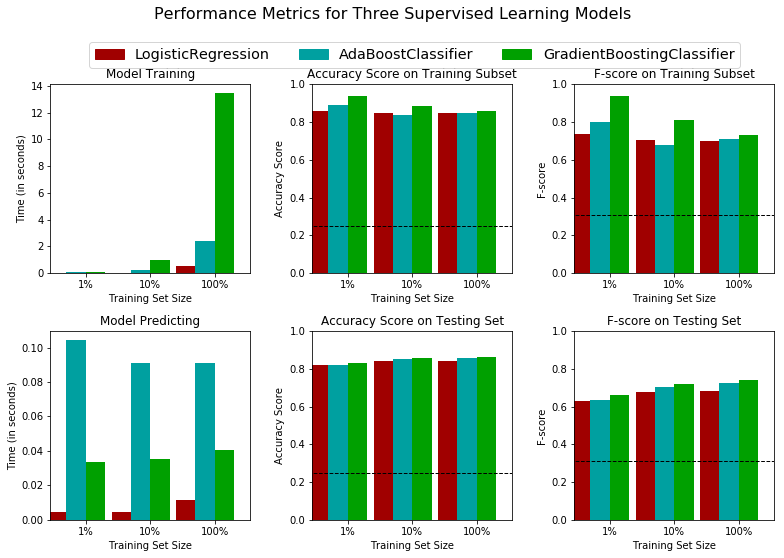

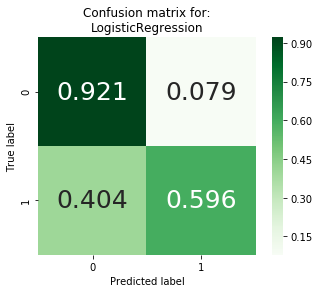

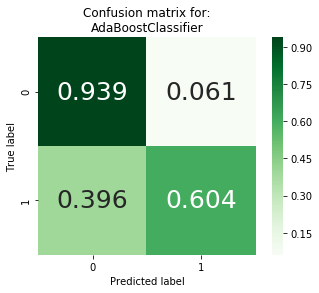

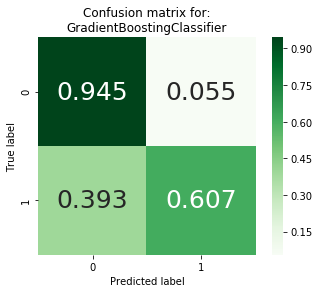

In [24]:
#Importing the three supervised learning models from sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression


#Initializing the three models
clf_A = LogisticRegression(random_state=42)
clf_B = AdaBoostClassifier(random_state=42)
clf_C = GradientBoostingClassifier(random_state=42)

#Calculating the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(samples_100/10)
samples_1 = int(samples_100/100)

#Collecting results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

#Running metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

import seaborn as sns
import visuals as vs
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
for i,model in enumerate([clf_A,clf_B,clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":25}, 
            cmap='Greens', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

----
## Improving Results
In this final section, I will choose from the three supervised learning models the *best* model to use on the student data. Then I will perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

Which of the three models is the most appropriate for the task of identifying individuals that make more than \$50,000?


Because of the sequential generation of the trees GradientBoostingClassifier tends to be a bit slower than the other models. In our project, we can observe that it takes 6-10x more time to train than the other two models and it is the second one in terms of predicting.
Gradient Boosting Classifier performs slightly better for all 3 dataset sizes both for training and testing set and both for the accuracy score and F-score. Moreover, both metrics decrease with the higher number of training samples and improve while increasing the training data points. These two events led to the better generalized model.
Taking into account the highest accuracy and F-score, acceptable training and testing times, model’s applicability for classification problems like these and its feature importance capabilities GradientBoostingClassifier seems to be the most appropriate for the task of identifying individuals that make more than $50,000.


### Question 4 - Describing the Model in Layman's Terms


GradientBoostingClassifier is a chain of decision trees each contributing to the final prediction.

At the beginning, it starts with simple solution to the prediction, i.e. saying that all person have an income of more than 50K. Later it checks how well this solution works and how the true value differs from the expected one. By creating a decision tree split it tries to identify which variables are the reason behind this difference. For example, the first split can be done between individuals who are not in a relationship (earning less than 50K) and those who are married (their income of more than 50K). Another example could be: people in a possession of a Master’s degree earn more than 50K while those with a Bachelor’s one don’t. This assumption might be a bit inaccurate, that’s why it is known as a weak learner. Despite that, the Gradient Boosting will keep testing, adding new learners discovering more important patterns in the data set. Each new tree decision is influenced by all the previous added trees minimizing the error. It will continue doing it until it will no longer reach any improvement by adding new trees.

Gradient Boosting has its own stopping parameters, for example: how many levels of trees it produces or how many splits of the data to produce within each tree. The final model runs through all those decision trees and gives us a prediction if an individual could be a potential donor or not.

### Model Tuning
Now I will fine tune the chosen model. I will use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. I will need to use the entire training set for this. I will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`] and [`sklearn.metrics.make_scorer`].
- Initialize the classifier I've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state I set before.
- Create a dictionary of parameters I wish to tune for the chosen model.
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [25]:
#Importing 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
#Initializing the classifier

clf = GradientBoostingClassifier(random_state = 42)

#Creating the parameters list
parameters = {'max_depth':[2,3,4,5,6,7,8]}

#Making an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

#Performing grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator = clf, param_grid = parameters, scoring = scorer)

#Fitting the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

#Getting the estimator
best_clf = grid_fit.best_estimator_

#Making predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

#Reporting the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8688
Final F-score on the testing data: 0.7483


### Question 5 - Final Model Evaluation

* What is the optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from my optimized model compare to the naive predictor benchmarks I found earlier in **Question 1**?_  

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8630       |      0.8688     |
| F-score        |      0.7395       |      0.7483     |


The optimized gradient boosting registered better results than the unoptimized model and the naive predictor benchmark.

The optimized model registered an accuracy score of 86.88% which is slighty greater than the unoptimized model (by 0.7%). The higher F-score was also delivered by the optimized one: 74.83% (higher by 1.2%).

The results of the optimized model are strongly higher in compare to the naive predictor benchmarks. This predictor is naive which means that in our case a person always makes more than $50.000 which led to the fact that both accuracy and precision are the same.

Overall, I am happy to see that the optimized model received better scores which signals the correctness of chosen parameters.


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell I will fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.

The first five features which seems to be the most appropriate ones for the prediction:

1. capital-gain: the more you gained, the higher probability your income is more than 50k.
2. capital-loss: similarly as the capital-loss: the less it is, the higher possibility of not reaching the income of 50k.
3. occupation: the income highly depends on a type of the occupation and a field of the work of an individual.
4. age: the income of a person with a higher seniority are relatively higher on average than the younger ones.
5. education: the higher level of education, the higher probability of the higher work position leading to the higher income.

### Extracting Feature Importance
I will use Gradient Boosting Classifier that has a `feature_importance_` attribute available for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

Right now I will need to implement the following:
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

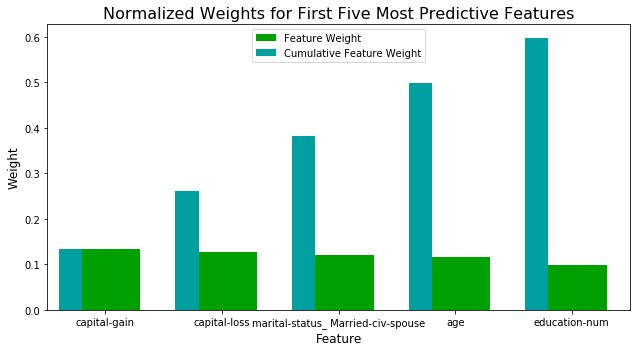

In [28]:
# TODO: Import a supervised learning model that has 'feature_importances_'


# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier().fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

The above chart displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features I discussed in **Question 6**?

This is in accordance with my thinking that with capital-gain, age, education an individual has likely bigger income.

In compare to my five feauters chosen and discussed in Question 6 one of them is missing in the above visualization. I am quite surprised that I cannot find the 'occupation' feature in the top 5 as I thought it was more correlated with the income. It is presented that the marital-status is more significant and, as being the 3rd feature, it influences the income strongly. We can read from this that the individual with the higher income can afford to be in the relationship and being with someone else generates a higher potential of a bigger income.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. Now I will use the same optimized model and train it on the same training set *with only the top five important features*. 

In [29]:
#Importing functionality for cloning a model
from sklearn.base import clone

#Reducing the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

#Training on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

#Making new predictions
reduced_predictions = clf.predict(X_test_reduced)

#Reporting scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8688
F-score on testing data: 0.7483

Final Model trained on reduced data
------
Accuracy on testing data: 0.8583
F-score on testing data: 0.7240


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?

On the reduced data with the reduced amount of features the accuracy amounted to 0.8583 and F-score to 0.7240. Despite the fact that both metrics are smaller than the trained model with all features, they are still high.
High accuracy score and F-score with the smaller data with the features reduction points to the fact that the training time for this data set of the project does not have a strong effect on these metrics. That’s why, if the training time was a factor, I would opt for the reduction of the data as my training set.